# Exercise 3

Start with the lattice from Exercise 2 and modify it so you can correct the chromaticity for both planes to zero.

Try first to calculate approximately the required strengths. Implement your correction scheme in your previous XSuite files and verify your calculation.

Use XSuite to compute the exact strengths required by matching the global parameters *dqx* and *dqy*. Compare the results with your calculations.

## Setup and lattice definitions:

In [225]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xobjects as xo
import xtrack as xt
import xpart as xp
import scipy

In [226]:
lcirc = 1000.0
lquad = 3.0
lbend = 5.0
max_dipole_field = 3.0
number_of_FODO = 20
number_of_dipoles = 4*number_of_FODO
k1 = 0.0098
pc_GeV = 20.0
lFODO = lcirc/number_of_FODO

In [227]:
env = xt.Environment()
env.vars({'lcirc': lcirc,
          'lquad': lquad, 
          'lbend': lbend, 
          'k1f': k1, 
          'k1d': -k1,
          'qtrim_f': 0,
          'qtrim_d': 0,
          'number_of_dipoles': number_of_dipoles,
          'angle.mb': 2.0*np.pi/number_of_dipoles,
          'k0.mb': 'angle.mb/lbend',
          'number_of_fodo': number_of_FODO,
          'lfodo': 'lcirc/number_of_fodo'
          })

env.particle_ref = xt.Particles(p0c=20e9, #eV
                                 q0=1, mass0=xt.PROTON_MASS_EV)

env.new('mb', xt.Bend, length='lbend', k0='k0.mb', h='k0.mb')

env.new('mb0', 'mb') #create each element with unique names in cell -- required for slicing of elements used later
env.new('mb1', 'mb')
env.new('mb2', 'mb')
env.new('mb3', 'mb')


env.new('mq', xt.Quadrupole, length='lquad')

env.new('mq.f', 'mq', k1='k1f + qtrim_f')
env.new('mq.d', 'mq', k1='k1d + qtrim_d')

cell = env.new_line(components=[
    env.new('marker_start', xt.Marker, at = '0'),
    env.place('mq.f', at=lquad*0.5),
    env.place('mb0', at='0.15 * lfodo + lquad * 0.5'),
    env.place('mb1', at='0.35 * lfodo  + lquad*0.5'),
    env.place('mq.d', at='0.50 * lfodo + lquad*0.5'),
    env.place('mb2', at='0.65 * lfodo + lquad*0.5'),
    env.place('mb3', at='0.85 * lfodo + lquad*0.5'),
    env.new('marker_end', xt.Marker, at='lfodo'),
])



In [228]:
cell.to_pandas()

,s,element_type,name,isthick,isreplica,parent_name,iscollective,element
0,0.0,Marker,marker_start,False,False,None,False,Marker(_dummy=np.int64(0))
1,0.0,Quadrupole,mq.f,True,False,None,False,"Quadrupole(k1=0.0098, k1s=0, length=3, num_mul..."
2,3.0,Drift,drift_1,True,False,None,False,Drift(length=3.5)
3,6.5,Bend,mb0,True,False,None,False,"Bend(length=5, k0=0.0157, k1=0, h=0.0157, mode..."
4,11.5,Drift,drift_2,True,False,None,False,Drift(length=5)
5,16.5,Bend,mb1,True,False,None,False,"Bend(length=5, k0=0.0157, k1=0, h=0.0157, mode..."
6,21.5,Drift,drift_3,True,False,None,False,Drift(length=3.5)
7,25.0,Quadrupole,mq.d,True,False,None,False,"Quadrupole(k1=-0.0098, k1s=0, length=3, num_mu..."
8,28.0,Drift,drift_4,True,False,None,False,Drift(length=3.5)
9,31.5,Bend,mb2,True,False,None,False,"Bend(length=5, k0=0.0157, k1=0, h=0.0157, mode..."


Create thin multipole elements for sextupole correction

In [229]:
env.vars({'ksf': 0.00, 'ksd' : 0.00 })
env.new('ms.f', xt.Multipole, knl = [0, 0, 'ksf'])
env.new('ms.d', xt.Multipole, knl = [0, 0, 'ksd'])
env.vars.get_table()

Table: 15 rows, 3 cols
name                      value expr                                    
t_turn_s                      0 None                                    
lcirc                      1000 None                                    
lquad                         3 None                                    
lbend                         5 None                                    
k1f                      0.0098 None                                    
k1d                     -0.0098 None                                    
qtrim_f                       0 None                                    
qtrim_d                       0 None                                    
number_of_dipoles            80 None                                    
angle.mb              0.0785398 None                                    
k0.mb                  0.015708 (vars['angle.mb'] / vars['lbend'])      
number_of_fodo               20 None                                    
lfodo                       

Add thin sextupoles to the lattice

In [230]:
cell.insert_element('ms.f', at = 'mq.f')
cell.insert_element('ms.d', at = 'mq.d')

In [231]:
line = env.new_line(components=[env.new('_start_point', xt.Marker)]+[env.place(cell)]*number_of_FODO)

line.to_pandas()

,s,element_type,name,isthick,isreplica,parent_name,iscollective,element
0,0.0,Marker,_start_point,False,False,None,False,Marker(_dummy=np.int64(0))
1,0.0,Marker,marker_start,False,False,None,False,Marker(_dummy=np.int64(0))
2,0.0,Multipole,ms.f,False,False,None,False,"Multipole(_order=np.int64(2), inv_factorial_or..."
3,0.0,Quadrupole,mq.f,True,False,None,False,"Quadrupole(k1=0.0098, k1s=0, length=3, num_mul..."
4,3.0,Drift,drift_1,True,False,None,False,Drift(length=3.5)
...,...,...,...,...,...,...,...,...
317,986.5,Drift,drift_5,True,False,None,False,Drift(length=5)
318,991.5,Bend,mb3,True,False,None,False,"Bend(length=5, k0=0.0157, k1=0, h=0.0157, mode..."
319,996.5,Drift,drift_6,True,False,None,False,Drift(length=3.5)
320,1000.0,Marker,marker_end,False,False,None,False,Marker(_dummy=np.int64(0))


In [232]:
# 2. Definition of the beam
line.particle_ref = xt.Particles(p0c=20e9, #eV
                                 q0=1, mass0=xt.PROTON_MASS_EV)

In [233]:
context = xo.ContextCpu()
line.build_tracker(_context=context)

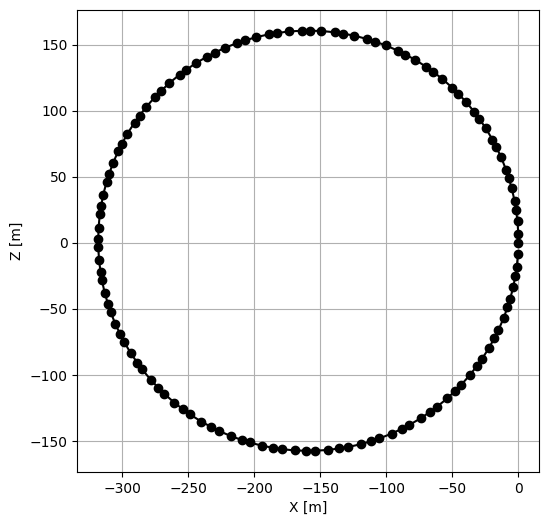

In [234]:
mySurvey = line.survey()
mySurvey = mySurvey.rows[r'^(mq|mb).*']
fig, ax = plt.subplots(figsize=(9, 6))
plt.plot(mySurvey.X, mySurvey.Z, 'o-', label="x", c="k")
plt.axis('square')
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
plt.grid()

In [235]:
myTwiss= line.twiss(method='4d')

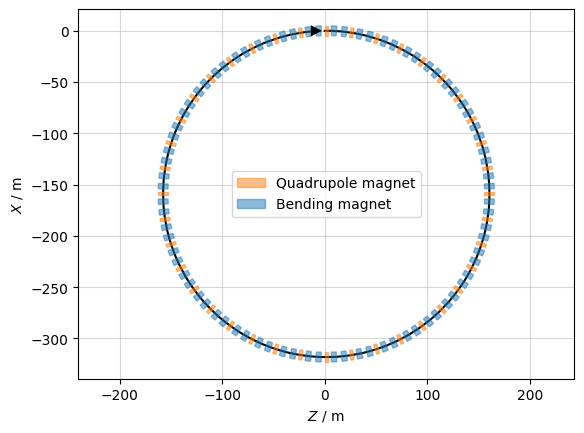

In [236]:
mySurvey.plot()

## Generate plots

In [237]:
import matplotlib.patches as patches

def plotLatticeSeries(ax,series, height=1., v_offset=0., color='r',alpha=0.5,lw=3):
    aux=series
    l = aux.length
    
    #l = np.min((aux.length, 0.001))
    ax.add_patch(
    
    patches.Rectangle(
        (aux.s-0*l, v_offset-height/2.),   # (x,y)
        l,          # width
        height,          # height
        color=color, alpha=alpha,lw=lw
    )
    )
    return;

(-5.0, 150.0)

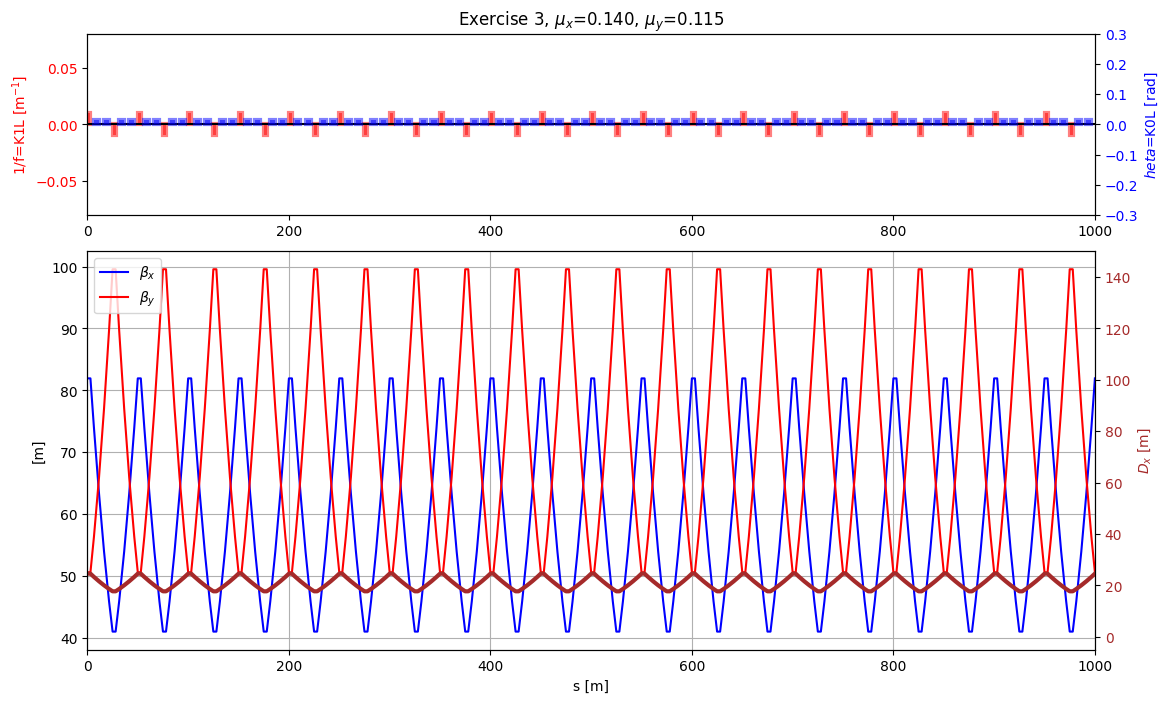

In [238]:
fig = plt.figure(figsize=(13,8))

ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')
s_pos = line.get_s_position()

for index, element in line.to_pandas().iterrows():
    try:
        el = line.get(element['name'])
        el.s = s_pos[index]
    except:
        pass
    if (element['element_type'] == 'Multipole'):
        plotLatticeSeries(plt.gca(), el, height=el.knl[2], v_offset=el.knl[2]/2, color='b')
    elif (element['element_type'] == 'Quadrupole'):
        plotLatticeSeries(plt.gca(), el, height=el.k1, v_offset=el.k1/2, color='r')

plt.xlim(0, line.get_length())
plt.ylim(-0.01, 0.01)


color = 'red'
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.08,.08)
plt.title(r'Exercise 3, $\mu_x$='+format(myTwiss.qx/20,'2.3f')+r', $\mu_y$='+ format(myTwiss.qy/20,'2.3f'))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('$\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)


#DF=myTwiss[(myTwiss['keyword']=='sbend')]
#for i in range(len(DF)):
#    aux=DF.iloc[i]
#    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

for index, element in line.to_pandas().iterrows():
    if (element['element_type'] == 'Bend'):
        el = line.get(element['name'])
        el.s = s_pos[index]
        plotLatticeSeries(plt.gca(), el, height=el.k0, v_offset=el.k0/2, color='b')

plt.ylim(-.3,.3)

plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwiss['s'],myTwiss['betx'],'b', label=r'$\beta_x$')
plt.plot(myTwiss['s'],myTwiss['bety'],'r', label=r'$\beta_y$')
plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$', lw=3)
ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor='brown')
plt.ylim(-5, 150)

## Computations

Let us start by considering a simple on-momentum tune shift from two Q-trim quadrupoles at $s_1$ and $s_2$. The linear response of the tune correction with respect to the quadrupole integrated gradients $\left(k1l(s_1),k1l(s_2)\right)^T$ is $$  \begin{pmatrix}
    \Delta Q_x \\\\ 
    \Delta Q_y
    \end{pmatrix}=\underbrace{\frac{1}{4\pi}
    \begin{pmatrix}
    \beta_x(s_1) & \beta_x(s_2)   \\\\
    -\beta_y(s_1) & -\beta_y(s_2) 
    \end{pmatrix}}_{M}
    \begin{pmatrix}
    k1l(s_1) \\\\
    k1l(s_2)
    \end{pmatrix},$$

Now let's think about sextupoles. 

The magnetic fields in a sextupole magnet are given by $$
B_x = -6B_3 xy $$$$
B_y = -3B_3(x^2 - y^2)
$$

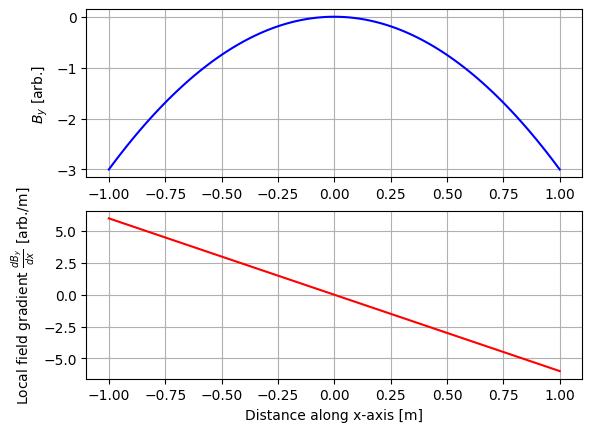

In [239]:
plt.subplot(211)
xs = np.linspace(-1, 1, 100)
bs = -3*xs**2
plt.plot(xs, bs, color = 'b')
plt.ylabel(r'$B_y$ [arb.]')
plt.grid()
plt.subplot(212)
plt.ylabel(r'Local field gradient $\frac{dB_y}{dx}$ [arb./m]')
plt.xlabel('Distance along x-axis [m]')
dbdxs = -6*xs
plt.plot(xs, dbdxs, color = 'r')
plt.grid()

As we move away from the reference orbit horizontally, we see a quadrupole component from the sextupole that increases in magnitude. (aside: if we moved vertically along the y-axis instead we would see a skew-quadrupole component from our normal sextupole: what if we used a skew sextupole instead?) This is known as a feed-down effect. 

This means that we have a possibility to have a transverse focussing that is dependent on the transverse position of the closed orbit. To take advantage of this to suppress chromaticity (a dependence of the focussing on the momentum of the beam), we need to link the transverse position of the closed orbit to the momentum of the beam: i.e. we need to take advantage of the dispersion. 

Assuming that we have two sextupoles at $s_1$ and $s_2$, then the linear response of chromaticity with respect to the sextupoles' integrated gradients $\left(k2l(s_1),k2l(s_2)\right)^T$ is $$
    \begin{pmatrix}
    \Delta\xi_x \\\\ 
    \Delta\xi_y
    \end{pmatrix}=\underbrace{\frac{1}{4\pi}
    \begin{pmatrix}
    \beta_x(s_1) D_x(s_1) & \beta_x(s_2) D_x(s_2)  \\\\ 
    -\beta_y(s_1) D_x(s_1) & -\beta_y(s_2) D_x(s_2)
    \end{pmatrix}}_{M}
    \begin{pmatrix}
    k2l(s_1) \\\\ 
    k2l(s_2)
    \end{pmatrix}.
    $$

We can determine the value of $(k2l(s_1),~k2l(s_2))^T$ by inverting this problem after having chosen  $s_1$ and $s_2$.

In [240]:
twissSextupolesOFF=myTwiss
dq1=myTwiss.dqx
dq2=myTwiss.dqy
fquadindex = twissSextupolesOFF['name']=='mq.f::0'
dquadindex = twissSextupolesOFF['name']=='mq.d::0'

bx1=twissSextupolesOFF.betx[fquadindex][0]
by1=twissSextupolesOFF.bety[fquadindex][0]
dx1=twissSextupolesOFF.dx[fquadindex][0]

bx2=twissSextupolesOFF.betx[dquadindex][0]
by2=twissSextupolesOFF.bety[dquadindex][0]
dx2=twissSextupolesOFF.dx[dquadindex][0]

####### Solution of the linear problem #######
M=np.array([[bx1*dx1, bx2*dx2],[-by1*dx1, -by2*dx2]])/4./np.pi
mySolution=np.linalg.inv(M)@np.array([[-dq1],[-dq2]])
print('=======================================')
print('This matrix gives the solution of the\nintegrated sextupole strength:')
display(mySolution)
print('=======================================')
# Clearly it has to be divided (shared) by the number of the cells

This matrix gives the solution of the
integrated sextupole strength:


array([[ 0.02248473],
       [-0.03058692]])

In [241]:
env.vars({'ksf' : mySolution[0][0]/number_of_FODO, 'ksd' : mySolution[1][0]/number_of_FODO})
twissSextupolesON = line.twiss(method = '4d')

In [242]:
print('=======================================')
print('Before applying the analytical solution')
print(f'DQ1={twissSextupolesOFF.dqx}')
print(f'DQ2={twissSextupolesOFF.dqy}')
print('=======================================')
print('After applying the analytical solution')
print(f'DQ1={twissSextupolesON.dqx}')
print(f'DQ2={twissSextupolesON.dqy}')
print('=======================================')

Before applying the analytical solution
DQ1=-1.8371131053251943
DQ2=-2.0694295308887334
After applying the analytical solution
DQ1=1.741473631966528e-06
DQ2=7.327471962526033e-10


## Can we use Xsuite matching to generate an equivalent (or better) solution?

In [243]:
env.vars['ksf'] = 0 #reset coefficients
env.vars['ksd'] = 0

opt = line.match(
            method = '4d',
            vary = [
                xt.VaryList(['ksf', 'ksd'], step=1e-4),
            ],
            targets = [
                xt.TargetSet(dqx=0, dqy=0, tol=1e-7)
            ]
    )

opt.log()

Matching: model call n. 34               



Table: 8 rows, 14 cols
iteration                   penalty alpha tag tol_met target_active hit_limits vary_active ...
0                           2.76722    -1     nn      yy            nn         yy         
1                       4.57673e-05     0     ny      yy            nn         yy         
2                       2.78146e-06     0     ny      yy            nn         yy         
3                       1.54844e-06     0     ny      yy            nn         yy         
4                       1.18471e-06     0     ny      yy            nn         yy         
5                        1.0694e-06     0     ny      yy            nn         yy         
6                       1.24736e-07     0     ny      yy            nn         yy         
7                       3.17524e-08     6     yy      yy            nn         yy         

In [244]:
twissSextupolesX = line.twiss(method = '4d')
print('=======================================')
print('Before applying the analytical solution')
print(f'DQ1={twissSextupolesOFF.dqx}')
print(f'DQ2={twissSextupolesOFF.dqy}')
print('=======================================')
print('After applying the analytical solution')
print(f'DQ1={twissSextupolesON.dqx}')
print(f'DQ2={twissSextupolesON.dqy}')
print('=======================================')
print('After XSuite optimisation')
print(f'DQ1={twissSextupolesX.dqx}')
print(f'DQ2={twissSextupolesX.dqy}')
print('=======================================')

Before applying the analytical solution
DQ1=-1.8371131053251943
DQ2=-2.0694295308887334
After applying the analytical solution
DQ1=1.741473631966528e-06
DQ2=7.327471962526033e-10
After XSuite optimisation
DQ1=3.175237850427948e-08
DQ2=0.0


## Why is the Xsuite result better than that of the analytic approach?

What effects are neglected by our analytic approximation?

Hint: let's compute the beta function at the sextupole positions with a momentum shift...

In [245]:
twdelt = line.twiss4d(delta0 = 0.01)

In [246]:
twdelt.rows['ms.*'].betx[:2],twdelt.rows['ms.*'].bety[:2]

(array([81.32938155, 40.57694093]), array([50.09219628, 98.77860404]))

In [247]:
line.twiss4d(delta0 = 0.0).rows['ms.*'].betx[:2],line.twiss4d(delta0 = 0.0).rows['ms.*'].bety[:2],

(array([81.92507781, 40.97419693]), array([50.56263368, 99.57211858]))

## Are the chosen sextupole positions optimal?

To answer this question we can approach it from a number of different directions. We can consider moving the positions of the sextupoles ($s_1$ and $s_2$) and solving the system again. What we would like to minimize is the $max(abs([k2l(s_1), k2l(s_1)]))$ for this particular correction.

In [248]:
cell.slice_thick_elements(
    slicing_strategies=[
        # Slicing with thin elements
        xt.Strategy(slicing=xt.Uniform(5)), # (1) Default applied to all elements
        xt.Strategy(slicing=xt.Uniform(6), element_type=xt.Drift),
])

line2 = env.new_line(components=[env.new('_start_point', xt.Marker)]+[env.place(cell)]*number_of_FODO) #remake ring with sliced version of cell
twissSextOFF2 = line2.twiss4d()

Slicing line:   0%|          | 0/16 [00:00<?, ?it/s]

In [249]:
# Loop in the positions
myS=np.unique(twissSextOFF2['s']) #ignore repeats of same s value (thin elements)
myS=myS[myS<=cell.get_length()] #limit to first cell only
mySolutions=[]
s1=[]
s2=[]
sd1 = []
sd2 = []
for i in myS:
    for j in myS:
        arg1 = np.argwhere(twissSextOFF2['s']==i)[0,0]
        bx1=twissSextOFF2['betx'][arg1]
        by1=twissSextOFF2['bety'][arg1]
        dx1=twissSextOFF2['dx'][arg1]
        arg2 = np.argwhere(twissSextOFF2['s']==j)[0,0]
        bx2=twissSextOFF2['betx'][arg2]
        by2=twissSextOFF2['bety'][arg2]
        dx2=twissSextOFF2['dx'][arg2]
        M=np.array([[bx1*dx1, bx2*dx2],[-by1*dx1, -by2*dx2]])/4./np.pi
        if np.abs(np.linalg.det(M))>1e-10:
            mySolutions.append(np.max(np.abs(np.linalg.inv(M)@np.array([[-dq1],[-dq2]]))))
            s1.append(i)
            s2.append(j)

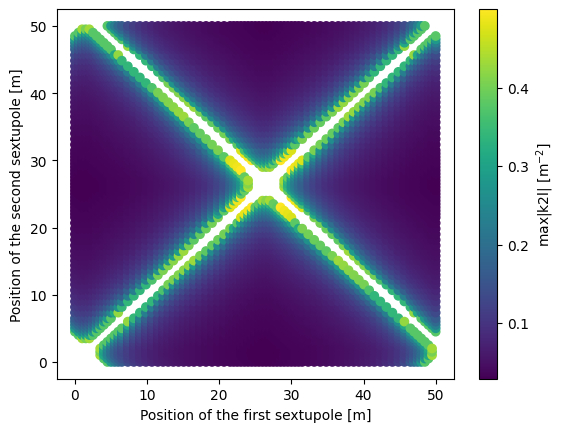

In [250]:
# Plotting the results
aux=np.array(mySolutions)
aux0=aux[aux<0.5]
aux1=np.array(s1)
aux2=np.array(s2)
plt.scatter(aux1[aux<0.5],aux2[aux<0.5], c=aux0)
plt.xlabel('Position of the first sextupole [m]')
plt.ylabel('Position of the second sextupole [m]')

myColorbar=plt.colorbar()
myColorbar.set_label('max|k2l| [m$^{-2}$]')

The positions on the diagonal and anti-diagonal of the previous plot give singular matrices. As expected, the best soution is to install the two sextupoles close to the F and D quadrupoles.

An alternative strategy to analyze this optimization problem, is to consider the condition number of the matrix as our main observable (replacing the  $max(abs([k2l(s_1), k2l(s_1)]))$ ).

In [251]:
#info about the 'cond' function. 
np.linalg.cond?

Signature:       np.linalg.cond(x, p=None)
Call signature:  np.linalg.cond(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function cond at 0x7fbc09da5630>
File:            ~/.local/lib/python3.10/site-packages/numpy/linalg/_linalg.py
Docstring:      
Compute the condition number of a matrix.

This function is capable of returning the condition number using
one of seven different norms, depending on the value of `p` (see
Parameters below).

Parameters
----------
x : (..., M, N) array_like
    The matrix whose condition number is sought.
p : {None, 1, -1, 2, -2, inf, -inf, 'fro'}, optional
    Order of the norm used in the condition number computation:

    =====  ============================
    p      norm for matrices
    =====  ============================
    None   2-norm, computed directly using the ``SVD``
    'fro'  Frobenius norm
    inf    max(sum(abs(x), axis=1))
    -inf   min(sum(abs(x), axis=1))
    1      max(sum(abs(x), axis=0))
    -1     m

In [252]:
# Loops in the positions 
myS=np.unique(twissSextOFF2['s'])
myS=myS[myS<=cell.get_length()]
mySolutionsConditioning=[]
s1Conditioning=[]
s2Conditioning=[]
for i in myS:
    for j in myS:
        arg1 = np.argwhere(twissSextOFF2['s']==i)[0,0]
        bx1=twissSextOFF2['betx'][arg1]
        by1=twissSextOFF2['bety'][arg1]
        dx1=twissSextOFF2['dx'][arg1]
        arg2 = np.argwhere(twissSextOFF2['s']==j)[0,0]
        bx2=twissSextOFF2['betx'][arg2]
        by2=twissSextOFF2['bety'][arg2]
        dx2=twissSextOFF2['dx'][arg2]
        M=np.array([[bx1*dx1, bx2*dx2],[-by1*dx1, -by2*dx2]])/4./np.pi
        mySolutionsConditioning.append(np.linalg.cond(M))
        s1Conditioning.append(i)
        s2Conditioning.append(j)

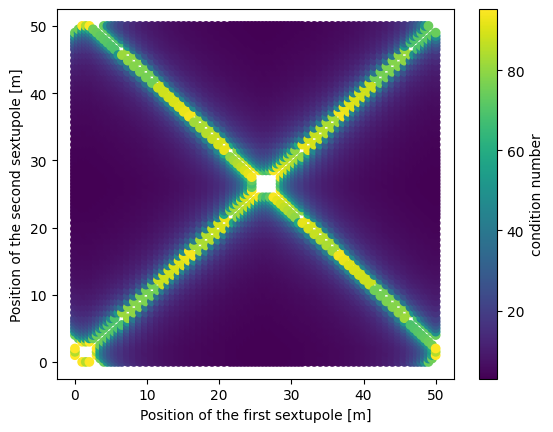

In [253]:
# Plotting the results
aux=np.array(mySolutionsConditioning)
myLimit=100
aux0=aux[aux<myLimit]
aux1=np.array(s1Conditioning)
aux2=np.array(s2Conditioning)
plt.scatter(aux1[aux<myLimit],aux2[aux<myLimit], c=aux0)
plt.xlabel('Position of the first sextupole [m]')
plt.ylabel('Position of the second sextupole [m]')

myColorbar=plt.colorbar()
myColorbar.set_label('condition number')

As expected, the conclusion is exactly equivalent.
Given that the maximum integrated strength of the sextupoles is $0.05/n_{cell}~m^{-2}$ (each sextupole has a bi-polar power supply), what is the reachable domain of ($\Delta\xi_x$,$\Delta\xi_y$)?

A simple (effective but inelegant) way to answer to this question is to consider a naive Montecarlo spanning all combinations of sextupole strengths and looking at the results in the chromaticity plane.


In [254]:
dq1=myTwiss.dqx
dq2=myTwiss.dqy
fquadindex = twissSextupolesOFF['name']=='mq.f::0'
dquadindex = twissSextupolesOFF['name']=='mq.d::0'
#aux=twissSextupolesOFF[(twissSextupolesOFF['name']=='qf:1').flatten()]
bx1=twissSextupolesOFF.betx[fquadindex][0]
by1=twissSextupolesOFF.bety[fquadindex][0]
dx1=twissSextupolesOFF.dx[fquadindex][0]

bx2=twissSextupolesOFF.betx[dquadindex][0]
by2=twissSextupolesOFF.bety[dquadindex][0]
dx2=twissSextupolesOFF.dx[dquadindex][0]

M=np.array([[bx1*dx1, bx2*dx2],[-by1*dx1, -by2*dx2]])/4./np.pi

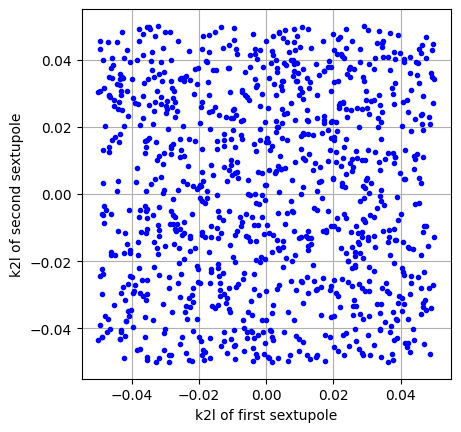

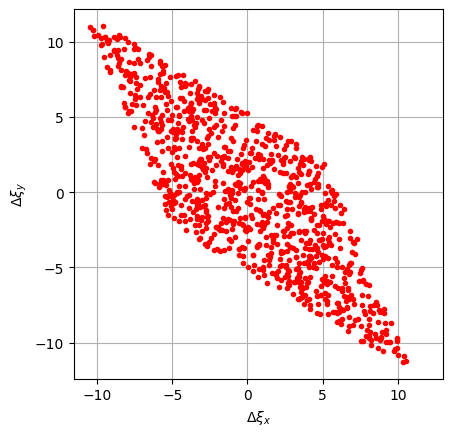

In [255]:
N=1000
myRandomX=(np.random.rand(2,N)-.5)*2*0.05
myFig1=plt.figure()
plt.plot(myRandomX[0,:],myRandomX[1,:],'.b')
plt.axis('equal');
plt.axis('square');
plt.xlabel('k2l of first sextupole')
plt.ylabel('k2l of second sextupole')
plt.grid()

myFig2=plt.figure()
myRandomY=M@myRandomX
plt.plot(myRandomY[0,:],myRandomY[1,:],'.r')
plt.axis('equal');
plt.axis('square');
plt.xlabel(r'$\Delta\xi_x$')
plt.ylabel(r'$\Delta\xi_y$')
plt.grid()

Though inelegant, the result suggests the alternative approach: we need in fact to transform only two vectors (in black in the following plot) to compute the effect on the chromaticity plane (parallelogram generated by the transformed vectors, in black in the following plot).

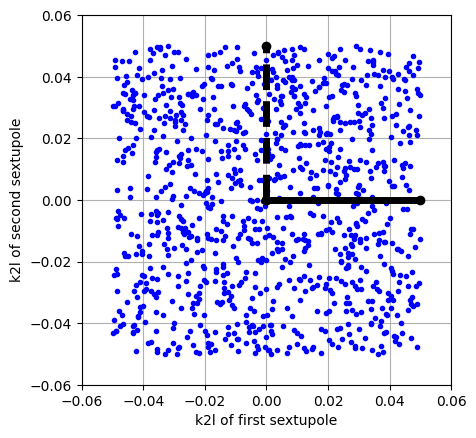

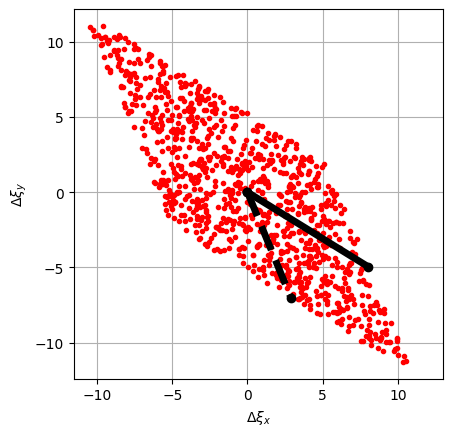

In [256]:
N=1000
myX=np.array([[0.05,0],[0,0.05]])
plt.plot(myRandomX[0,:],myRandomX[1,:],'.b')
plt.axis('equal');
plt.axis('square');
plt.plot([0,myX[0,0]],[0,myX[0,1]],'k-o', lw=5)
plt.plot([0,myX[1,0]],[0,myX[1,1]],'k--o', lw=5)
plt.xlim(-0.06,0.06)
plt.ylim(-0.06,0.06)
plt.xlabel('k2l of first sextupole')
plt.ylabel('k2l of second sextupole')
plt.grid()

plt.figure()
myRandomY=M@myRandomX
plt.plot(myRandomY[0,:],myRandomY[1,:],'.r')

myY=M@myX

plt.plot([0,myY[0,0]],[0,myY[1,0]],'k-o', lw=5)
plt.plot([0,myY[0,1]],[0,myY[1,1]],'k--o', lw=5)

plt.axis('equal');
plt.axis('square');
plt.xlabel(r'$\Delta\xi_x$')
plt.ylabel(r'$\Delta\xi_y$')
plt.grid()

## Tune knobs

An approach similar to the one used for the chromaticity correction can be adopted for the tune correction. In the sequence, we have already defined the variables we will use for the corrections (qtrim_f, qtrim_d).

After having computed (using XSuite) the response of the qtrim_f and qtrim_d, using the matrix relation described to the introduction and not with XSuite, compute
$\beta$-function at the F/D quadrupoles. Compare with XSuite.

In [257]:
qx_ref = myTwiss.qx
qy_ref = myTwiss.qy
qtrim_f = 0.00000001
env.vars['qtrim_f'] = qtrim_f
qTwiss = line.twiss(method='4d')
deltaQx_f = qTwiss['qx']-qx_ref
deltaQy_f = qTwiss['qy']-qy_ref

In [258]:
env.vars['qtrim_f'] = 0 
env.vars['qtrim_d'] = qtrim_f
qTwiss = line.twiss(method='4d')
deltaQx_d = qTwiss['qx']-qx_ref
deltaQy_d = qTwiss['qy']-qy_ref

In [259]:
M_Qtrim=np.array([[deltaQx_f, deltaQx_d],[deltaQy_f, deltaQy_d]])/qtrim_f/number_of_FODO
M_Qtrim*np.pi*4

array([[ 249.38551037,  121.02235745],
       [-149.39763975, -303.12193953]])

The previous equation has to be compared with the matrix $$ \begin{pmatrix}
\beta_x(s_1) & \beta_x(s_2)\\
-\beta_y(s_1) & -\beta_y(s_2) 
\end{pmatrix} $$ 
This is an example of k-modulation measurement in Xsuite. Why there is a residual error? (No hint this time).

In [260]:
s1i = np.argwhere(myTwiss['name']=='mq.f::0')
s2i = np.argwhere(myTwiss['name']=='mq.d::0')
bx1 = myTwiss['betx'][s1i][0][0]
bx2 = myTwiss['betx'][s2i][0][0]
by1 = myTwiss['bety'][s1i][0][0]
by2 = myTwiss['bety'][s2i][0][0]

M_B = np.array([[bx1, bx2],[-by1, -by2]])
M_B*np.pi

array([[ 257.37522205,  128.72423572],
       [-158.84719852, -312.81503625]])

## Can you extract the first-order matrix of the lattice? 

In [261]:
rmat = myTwiss.get_R_matrix('_start_point', '_end_point')
rmat4 = rmat[:4,:4] 
rmat2 = rmat[:2,:2] 
rmat4

array([[ 1.45898665e+00, -7.72982839e+01,  0.00000000e+00,
         0.00000000e+00],
       [ 2.79683568e-02, -7.96378762e-01,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  4.71540220e-01,
         4.87089052e+01],
       [ 0.00000000e+00,  0.00000000e+00, -3.02895326e-02,
        -1.00812179e+00]])

Compute the tune from the first-order matrix and compare to Twiss calculation

In [262]:
print(np.abs(myTwiss.qx-np.round(myTwiss.qx)), np.abs(myTwiss.qy-np.round(myTwiss.qy)))
np.angle(np.linalg.eig(rmat4)[0])/np.pi/2

0.1962557258086588 0.2932293996251012


array([ 0.19625573, -0.19625573,  0.2932294 , -0.2932294 ])

## Can we compute R-matrix WITHOUT prior knowledge of the optics?

i.e. without using line.twiss().get_R_matrix()

Let's start by tracking some particles.

The line already has an associated tracker


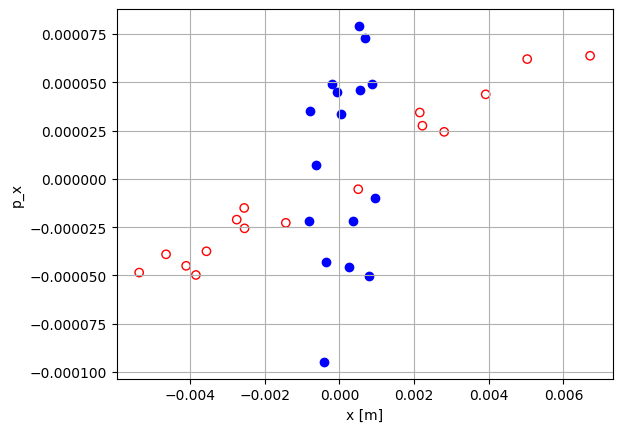

In [263]:
dx = 0.001
dpx = 1e-4
N = 16
X_i = np.array([np.random.uniform(-dx, dx, N), np.random.uniform(-dpx, dpx, N)])
line.build_tracker()
particles = line.build_particles(x = X_i[0, :], px = X_i[1, :])
plt.scatter(particles.x, particles.px, marker = 'o', color = 'b', label = 'Initial coordinates')
line.track(particles, num_turns = 1, turn_by_turn_monitor = True)
plt.scatter(particles.x, particles.px, marker = 'o', facecolors = 'none', edgecolors = 'r', label = 'Tracked positions')
X_f = np.array([particles.x, particles.px])
plt.xlabel('x [m]')
plt.ylabel(r'p_x')
plt.grid()

FITTED MATRIX
[[ 1.44791959e+00 -7.69263746e+01]
 [ 2.77556173e-02 -7.87735297e-01]]
TWISS MATRIX FROM XSUITE
[[ 1.45898665e+00 -7.72982839e+01]
 [ 2.79683568e-02 -7.96378762e-01]]
FITTED MATRIX DETERMINANT
0.9945616421254816
1.0000000000000007


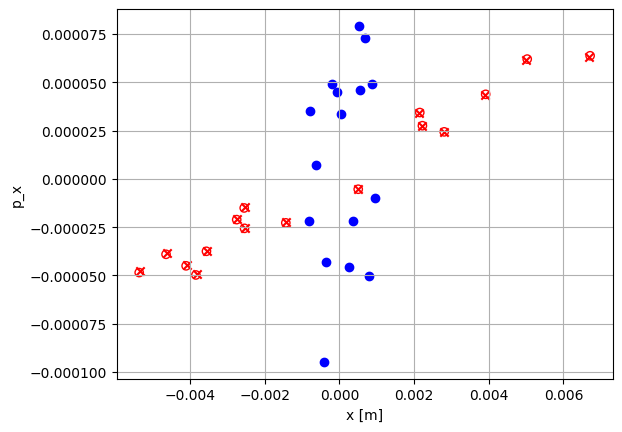

In [264]:
plt.scatter(*X_i, marker = 'o', color = 'b', label = 'Initial coordinates')
plt.scatter(particles.x, particles.px, marker = 'o', facecolors = 'none', edgecolors = 'r', label = 'Tracked positions')
def fun(M, X_i, X_f):
    m11, m12, m21, m22 = M
    mat = np.array([[m11, m12],
                    [m21, m22]])
    n = X_i.shape[1]
    X_i = np.vstack((X_i[0,:],X_i[1,:])).ravel('F')
    X_f = np.vstack((X_f[0,:],X_f[1,:])).ravel('F')
    mat_n = np.kron(np.eye(n),mat)
    return np.linalg.norm(mat_n@X_i - X_f)

opt = scipy.optimize.least_squares(fun, [1, 1e-15, 1e-15, 1], args = [X_i, X_f], gtol = 1e-13)
mat = np.array([opt.x[:2], opt.x[2:]])

X_fm = mat@X_i

plt.scatter(*X_fm, marker = 'x', color = 'r', label = 'Positions computed from fitted matrix')
plt.xlabel('x [m]')
plt.ylabel(r'p_x')
plt.grid()

print('FITTED MATRIX')
print(mat)
print('TWISS MATRIX FROM XSUITE')
print(rmat2)
print('FITTED MATRIX DETERMINANT')
print(np.linalg.det(mat))
print(np.linalg.det(rmat2))

However, if we increase the amplitudes of our initial particles... 

The line already has an associated tracker


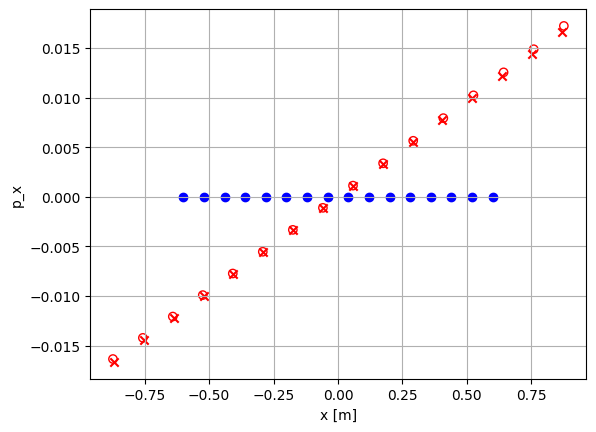

In [265]:
dx = 0.6
dpx = 0
N = 16
nturns = 1
X_i = np.array([np.linspace(-dx, dx, N), np.random.uniform(-dpx, dpx, N)])
line.build_tracker()
particles = line.build_particles(x = X_i[0, :], px = X_i[1, :])
plt.scatter(particles.x, particles.px, marker = 'o', color = 'b', label = 'Initial coordinates')
line.track(particles, num_turns = nturns, turn_by_turn_monitor = True)
plt.scatter(particles.x, particles.px, marker = 'o', facecolors = 'none', edgecolors = 'r', label = 'Tracked positions')
X_f = np.array([particles.x, particles.px])

plt.scatter(*(np.linalg.matrix_power(mat, nturns)@X_i), marker = 'x', color = 'r')
plt.xlabel('x [m]')
plt.ylabel(r'p_x')
plt.grid()

The matrix tracking is not too bad (in a more nonlinear machine we would see a larger discrepancy!) but it cannot predict the large-amplitude motion with just linear modelling. 

The line already has an associated tracker
[-0.6  0. ]
(2, 16)
(2, 16)
(2,)


Text(0, 0.5, '$p_x$ with respect to reference particle')

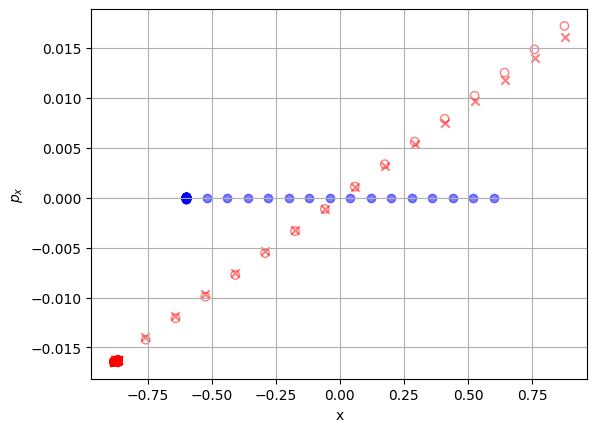

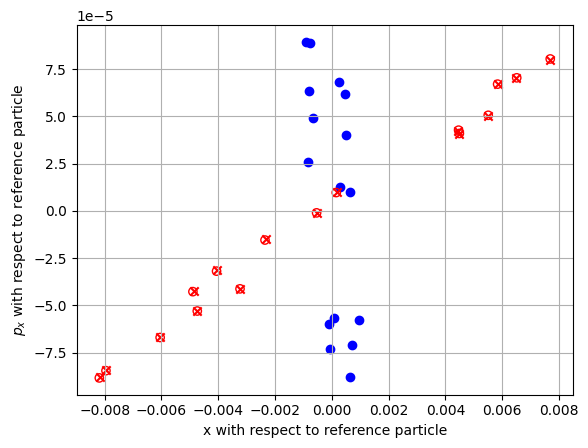

In [267]:
ddx = 0.001
ddpx = 1e-4
N = 16

X_j = np.array([np.random.uniform(-ddx, ddx, N), np.random.uniform(-ddpx, ddpx, N)])
line.build_tracker()
X_0 = X_i[:,0]
print(X_0)
X_0s = np.vstack([X_0]*N).T
X_1 = X_f[:,0]
X_1s = np.vstack([X_1]*N).T

print(X_j.shape)
print(X_0s.shape)
particles = line.build_particles(x = X_j[0, :]+X_0[0], px = X_j[1, :]+X_0[1])#, y = X_i[:,2], py = X_i[:,3])
plt.scatter(particles.x.T, particles.px.T, color = 'b')
line.track(particles, num_turns = 1, turn_by_turn_monitor = True)
plt.scatter(particles.x.T, particles.px.T, marker = 'o', facecolors = 'none', edgecolors = 'r')
X_fj = np.array([particles.x, particles.px])

print(X_0.shape)
opt = scipy.optimize.least_squares(fun, [1, 1e-15, 1e-15, 1], args = [X_j, X_fj-X_1s], gtol = 2.32e-16)
mat = np.array([opt.x[:2], opt.x[2:]])

plt.scatter(*X_i, color = 'b', alpha = 0.5)
plt.scatter(*X_f, marker = 'o', facecolors = 'none', edgecolors = 'r', alpha  = 0.5)
plt.scatter(*X_fj, marker = 'o', facecolors = 'none', edgecolors = 'r', )

X_fmj = mat@X_j + X_1s

plt.scatter(*X_fmj, color = 'r', marker = 'x')

plt.scatter(*(np.linalg.matrix_power(mat, nturns)@X_i), marker = 'x', color = 'r', alpha = 0.5)
plt.grid()
plt.xlabel('x')
plt.ylabel(r'$p_x$')


plt.figure()
plt.scatter(*(X_j), color = 'b')
plt.scatter(*(X_fj-X_1s), marker = 'o', facecolors = 'none', edgecolors = 'r')
plt.scatter(*(mat@X_j), marker = 'x', color = 'r')
plt.grid()
plt.xlabel('x with respect to reference particle')
plt.ylabel(r'$p_x$ with respect to reference particle')


What does this tell us about:
- the dynamics for small displacements around a reference point?
- constructing general higher-order maps?

# Tracking with non-linear elements

In [268]:
mytwiss = line.twiss(method="4d")

n_part = 20
particles = line.build_particles(
                        x = np.linspace(0, 1e-2, n_part))

n_turns = 1000
line.particle_ref = xt.Particles(p0c=20e9, #eV
                                 q0=1, mass0=xt.PROTON_MASS_EV)

context = xo.ContextCpu()
line.build_tracker(_context=context)

line.track(particles, num_turns=n_turns, turn_by_turn_monitor=True)

The line already has an associated tracker


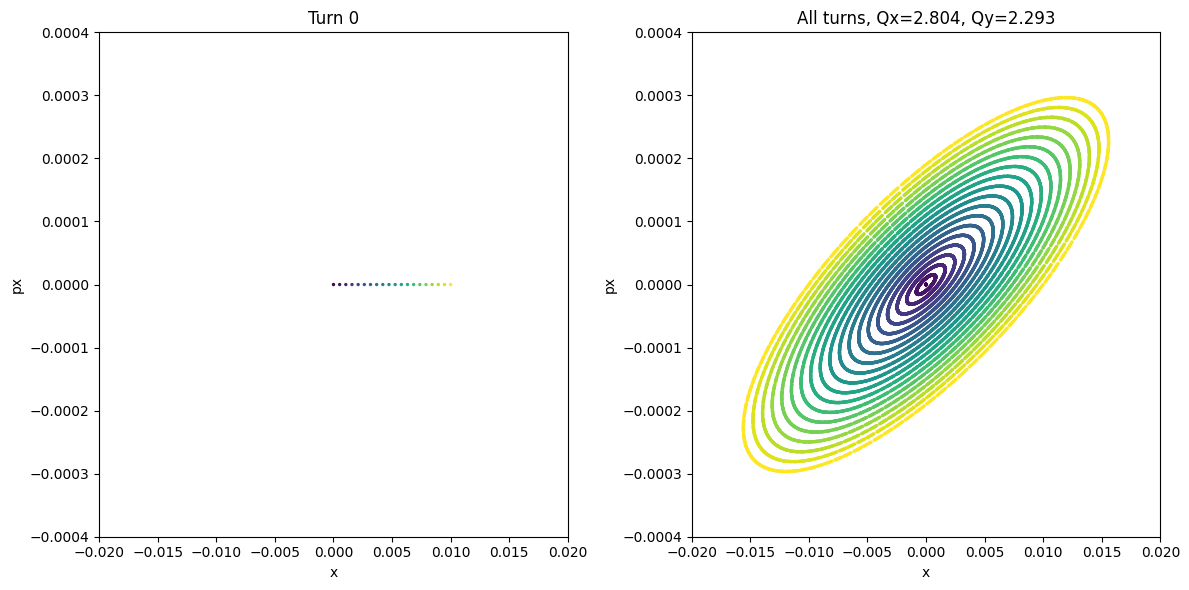

In [269]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
plt.sca(ax[0])
plt.scatter(line.record_last_track.x[:,0], line.record_last_track.px[:,0], c=line.record_last_track.particle_id[:,0], s=2)
plt.xlim(-0.02, 0.02)
plt.ylim(-4e-4, 4e-4)
plt.title("Turn 0")
plt.xlabel("x")
plt.ylabel("px")

plt.sca(ax[1])
plt.scatter(line.record_last_track.x, line.record_last_track.px, c=line.record_last_track.particle_id, s=2)
plt.xlim(-0.02, 0.02)
plt.ylim(-4e-4, 4e-4)
qx = round(mytwiss.qx,3)
qy = round(mytwiss.qy,3)
plt.title(f"All turns, Qx={qx}, Qy={qy}")

plt.xlabel("x")
plt.ylabel("px")
fig.tight_layout()


The line already has an associated tracker
Matching: model call n. 16               



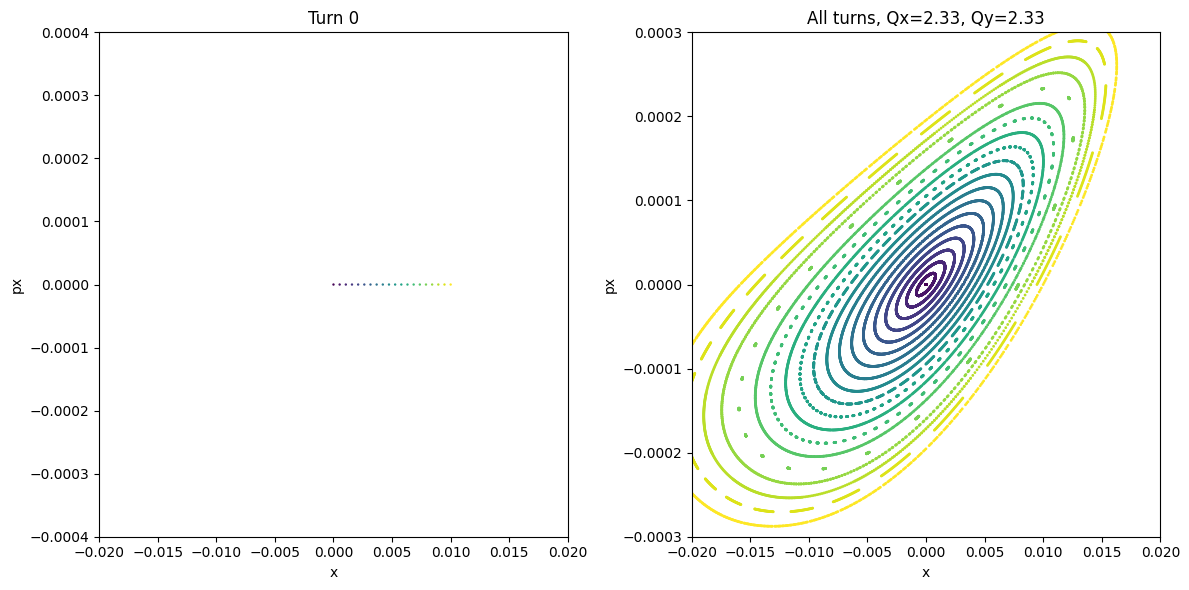

In [270]:


ksf_s = [0.9] #np.linspace(0, 10, 10)

for ksf in ksf_s:
    line.vars['ksf'] = ksf
    line.vars['ksd'] = -ksf

    n_part = 60
    n_part = 20
    particles = line.build_particles(
                            x = np.linspace(0, 1e-2, n_part))

    x = np.linspace(0, 1e-2, n_part)
    initial_action = x**2/mytwiss["betx"][0]
    n_turns = 1000
    # 2. Definition of the beam
    line.particle_ref = xt.Particles(p0c=20e9, #eV
                                     q0=1, mass0=xt.PROTON_MASS_EV)
    
    context = xo.ContextCpu()
    line.build_tracker(_context=context)
    
    opt = line.match(
                method = '4d',
                vary = [
                    xt.VaryList(['k1f', 'k1d'], step=1e-4),
                ],
                targets = [
                    xt.TargetSet(qx=2.33, qy=2.33, tol=1e-7)
                ]
        )
    
    mytwiss = line.twiss(method="4d")
    line.track(particles, num_turns=n_turns, turn_by_turn_monitor=True)
    
    fig, ax = plt.subplots(ncols=2, figsize=(12,6))
    plt.sca(ax[0])
    plt.scatter(line.record_last_track.x[:,0], line.record_last_track.px[:,0], c=line.record_last_track.particle_id[:,0], s=0.5)
    plt.xlim(-0.02, 0.02)
    plt.ylim(-4e-4, 4e-4)
    plt.title("Turn 0")
    plt.xlabel("x")
    plt.ylabel("px")
    
    plt.sca(ax[1])
    plt.scatter(line.record_last_track.x, line.record_last_track.px, c=line.record_last_track.particle_id, s=1)
    plt.xlim(-0.02, 0.02)
    plt.ylim(-3e-4, 3e-4)
    qx = round(mytwiss.qx,3)
    qy = round(mytwiss.qy,3)
    plt.title(f"All turns, Qx={qx}, Qy={qy}")
    
    plt.xlabel("x")
    plt.ylabel("px")
    fig.tight_layout()



# 1 turn map and non linear elements

In [271]:
qx = 0.27
qy = 0.295

elements = {
    'segment_map': xt.LineSegmentMap(
            qx=qx, qy=qy, det_xx = 0, betx=1)
}
line = xt.Line(elements=elements,
               element_names=['segment_map'])

line.twiss_default['method'] = '4d'

sextupole = xt.Multipole(knl=[0,0, 0.5])
line.insert_element(element=sextupole, name='sextupole', index=0)
octupole = xt.Multipole(knl=[0.0,0.0, 0.0, -0.8])
line.insert_element(element=octupole, name='octupole', index=0)

line.particle_ref = xt.Particles(p0c=20e9,
                                 q0=1, mass0=xt.PROTON_MASS_EV)
context = xo.ContextCpu()
line.build_tracker(_context = context)

In [272]:
n_r = 40
n_theta = 40

x_normalized, y_normalized, r_xy, theta_xy = xp.generate_2D_polar_grid(
    r_range=(0.01, 10.), 
    theta_range=(np.deg2rad(0.1), np.pi/2),
    nr=n_r, ntheta=n_theta)

n_part = len(x_normalized)

particles = line.build_particles(
    x_norm=x_normalized, px_norm=0,
    y_norm=y_normalized, py_norm=0,
    nemitt_x=2e-1, nemitt_y=2e-1, # normalized emittances
    delta=0, method="4d")

print(len(x_normalized))

1600


In [273]:
n_turns = 2000

In [274]:
mytwiss = line.twiss(method="4d")
line.track(particles, num_turns=n_turns, turn_by_turn_monitor=True)

In [275]:
import nafflib
qx = [nafflib.tune(line.record_last_track.x[i, :]) for i in range(n_part)]
qy = [nafflib.tune(line.record_last_track.y[i, :]) for i in range(n_part)]

Text(0, 0.5, 'Qy')

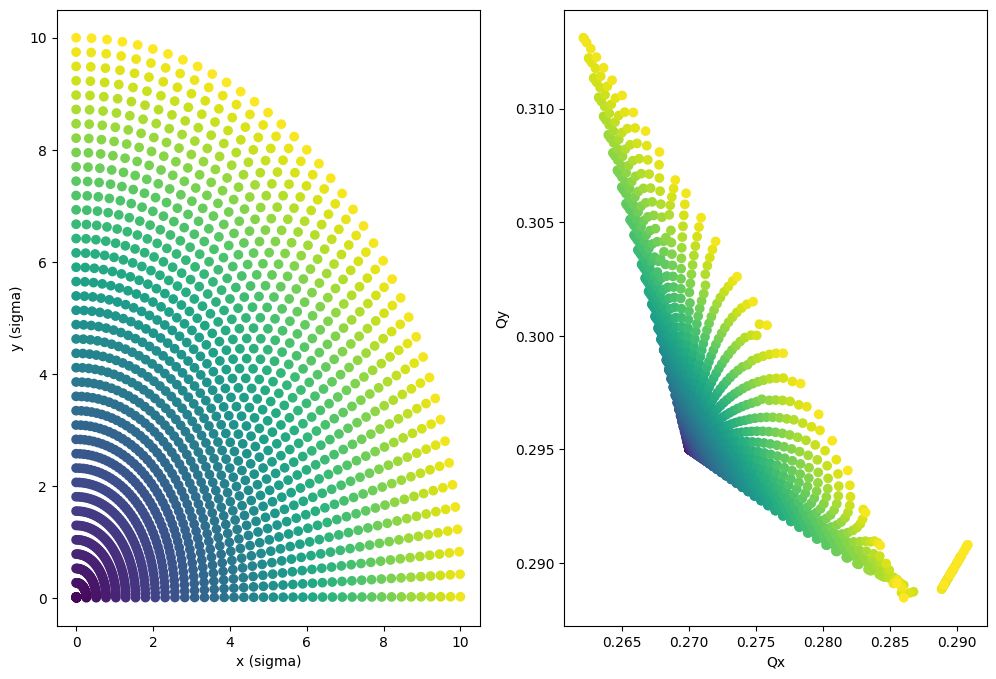

In [276]:
fig, ax = plt.subplots(figsize=(12,8), ncols=2)
plt.sca(ax[0])
plt.scatter(x_normalized, y_normalized, c=line.record_last_track.particle_id[:, 0])
plt.xlabel("x (sigma)")
plt.ylabel("y (sigma)")

plt.sca(ax[1])
plt.scatter(qx, qy,  c=line.record_last_track.particle_id[:, 0])
plt.xlabel("Qx")
plt.ylabel("Qy")

In [277]:
import nafflib
qx1 = np.array([nafflib.tune(line.record_last_track.x[i, 0:n_turns//2]) for i in range(n_part)])
qy1 = np.array([nafflib.tune(line.record_last_track.y[i, 0:n_turns//2]) for i in range(n_part)])
qx2 = np.array([nafflib.tune(line.record_last_track.x[i, n_turns//2:]) for i in range(n_part)])
qy2 = np.array([nafflib.tune(line.record_last_track.y[i, n_turns//2:]) for i in range(n_part)])
diffusion = np.log10(np.sqrt((qx1-qx2)**2 + (qy1-qy2)**2 ))
diffusion[np.isinf(diffusion)] = -60
diffusion

/tmp/ipykernel_94534/754835368.py:6: RuntimeWarning: divide by zero encountered in log10
  diffusion = np.log10(np.sqrt((qx1-qx2)**2 + (qy1-qy2)**2 ))


array([-16.25561977, -60.        , -16.25561977, ...,  -5.76529295,
        -6.09462967,  -5.84782457])

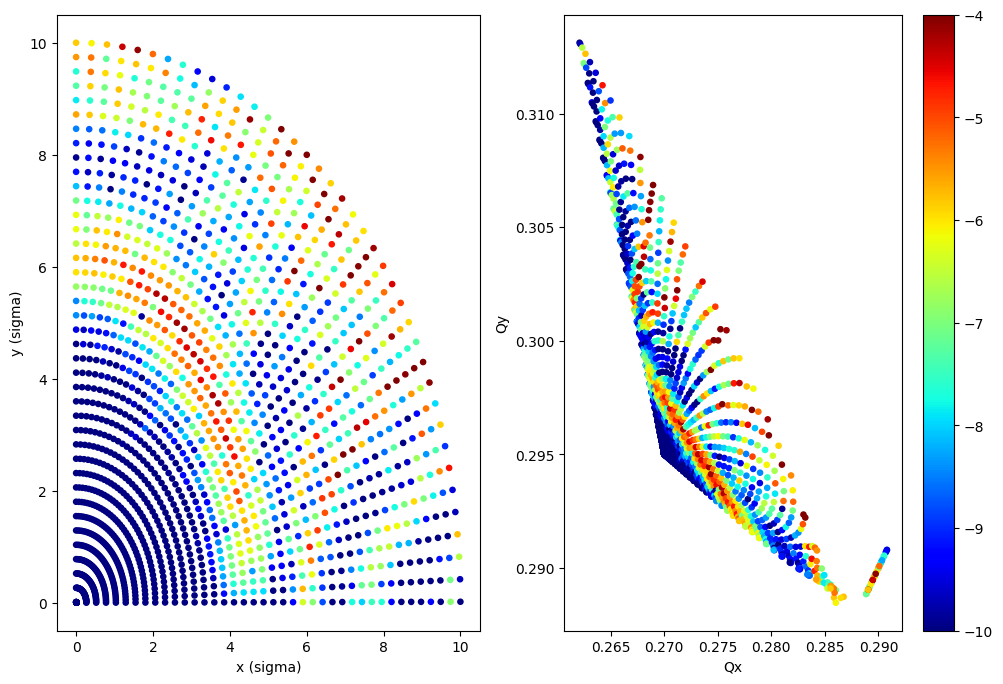

In [278]:
fig, ax = plt.subplots(figsize=(12,8), ncols=2)
plt.sca(ax[0])
plt.scatter(x_normalized, y_normalized, c=diffusion, s=14, cmap="jet", vmin=-10, vmax=-4)
plt.xlabel("x (sigma)")
plt.ylabel("y (sigma)")

plt.sca(ax[1])
plt.scatter(qx, qy,  c=diffusion, s=14, cmap="jet", vmin=-10, vmax=-4)
plt.xlabel("Qx")
plt.ylabel("Qy")
plt.colorbar()